## Evaluate Gradient-based Inverse Design Maximize Qfwd while Minimize Qback
---

### <u> Import modules <u/>

In [19]:
import tensorflow as tf
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import time
from tensorflow.keras.optimizers import Adam
from tensorflow import keras
from wgangp_model import load_generator, inverse_transform_synthetic_data
from utils_plot import plot_best_geometries_by_weights

## Set dynamic GPU memory growth

In [20]:
# Check if GPU available
gpus = tf.config.list_physical_devices("GPU")
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU is available and set to memory growth mode.")
    except RuntimeError as e:
        print(e)
else:
    print("No GPU detected by TensorFlow.")

GPU is available and set to memory growth mode.


### Define the own resblock class

keras requires custom classes to be defined for being able to reload

In [21]:
# decorator to register the custom resblock to allow serialziation and re-loading
@keras.utils.register_keras_serializable()  # for keras3
class ResBlock1D(keras.Model):
    def __init__(self, filters, kernel_size=3, convblock=False, **kwargs):
        super(ResBlock1D, self).__init__(**kwargs)
        self.filters = filters
        self.kernel_size = kernel_size

        # setup all necessary layers
        self.conv1 = keras.layers.Conv1D(filters, kernel_size, padding="same")
        self.bn1 = keras.layers.BatchNormalization()

        self.conv2 = keras.layers.Conv1D(filters, kernel_size, padding="same")
        self.bn2 = keras.layers.BatchNormalization()

        # self.relu = keras.layers.LeakyReLU()
        self.relu = keras.layers.LeakyReLU(negative_slope=0.01)

        self.convblock = convblock
        if self.convblock:
            self.conv_shortcut = keras.layers.Conv1D(filters, 1)

    def call(self, input_tensor, training=False):
        x = self.conv1(input_tensor)
        x = self.bn1(x, training=training)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x, training=training)

        # add shortcut. optionally pass it through a Conv
        if self.convblock:
            x_sc = self.conv_shortcut(input_tensor)
        else:
            x_sc = input_tensor
        x += x_sc
        return self.relu(x)

    def get_config(self):
        base_config = super().get_config()
        return {
            "convblock": self.convblock,
            "filters": self.filters,
            "kernel_size": self.kernel_size,
            **base_config,
        }

## Relaod the data scaler

In [22]:
# preprocessor path
preprocessor_path = "datasets/scaler_particle_geometries.pkl"
scaler_Qfwd_path = "datasets/scaler_Qfwd.pkl"
scaler_Qback_path = "datasets/scaler_Qback.pkl"

# Load the preprocessors and scalers
with open(preprocessor_path, "rb") as f:
    preprocessor = pickle.load(f)
with open(scaler_Qfwd_path, "rb") as f:
    scaler_Qfwd = pickle.load(f)
with open(scaler_Qback_path, "rb") as f:
    scaler_Qback = pickle.load(f)

## Reload the forward and wgangp model

In [23]:
forward_path = "models/resnet_Mie_predictor.keras"
wgangp_path = "models/wgangp_generator.h5"

forward_model = keras.models.load_model(forward_path)
generator = load_generator(wgangp_path)

# Reload Result from maximize Qfwd while minimize Qback problem in 04c script

In [ ]:
results = []
results_path = 'best_geometries/gradient_max_min_problem_lrfixed.pkl'

# Load the preprocessors and scalers
with open(results_path, 'rb') as f:
    results = pickle.load(f)

## Mie Utils

In [24]:
# %% --- Mie
def get_Mie_spec(wavelengths, r_core, r_shell, mat_core, mat_shell, n_env):

    k0 = 2 * np.pi / wavelengths
    n_core = mat_core.get_refindex(wavelengths)
    n_shell = mat_shell.get_refindex(wavelengths)

    res = pymiecs.Q(
        k0,
        r_core=r_core,
        n_core=n_core,
        r_shell=r_shell,
        n_shell=n_shell,
        n_env=n_env.real**0.5,  # host medium must be lossless
    )
    return (
        res["qsca"],
        res["qback"],
        res["qfwd"],
    )

In [25]:
import pymiecs

Si = pymiecs.materials.MaterialDatabase("Si")
SiO2 = pymiecs.materials.MaterialDatabase("SiO2")
Si3N4 = pymiecs.materials.MaterialDatabase("Si3N4")
Au = pymiecs.materials.MaterialDatabase("Au")
Ag = pymiecs.materials.MaterialDatabase("Ag")
ZrO2 = pymiecs.materials.MaterialDatabase("ZrO2")
TiO2 = pymiecs.materials.MaterialDatabase("TiO2")


# Define a function to map material names to material objects
def get_material(material_name):
    if material_name == "Si":
        return Si
    elif material_name == "SiO2":
        return SiO2
    elif material_name == "Au":
        return Au
    elif material_name == "Ag":
        return Ag
    elif material_name == "Si3N4":
        return Si3N4
    elif material_name == "ZrO2":
        return ZrO2
    elif material_name == "TiO2":
        return TiO2
    else:
        raise ValueError(f"Unknown material: {material_name}")

## Define Target


In [27]:
wavelengths = np.linspace(400, 800, 64)
print(f"wavelengths:{wavelengths}")
target_lambda_index = np.argmin(np.abs(wavelengths - 705))

print(
    f"Target wavelength index {target_lambda_index} ({wavelengths[target_lambda_index]} nm)"
)

wavelengths:[400.         406.34920635 412.6984127  419.04761905 425.3968254
 431.74603175 438.0952381  444.44444444 450.79365079 457.14285714
 463.49206349 469.84126984 476.19047619 482.53968254 488.88888889
 495.23809524 501.58730159 507.93650794 514.28571429 520.63492063
 526.98412698 533.33333333 539.68253968 546.03174603 552.38095238
 558.73015873 565.07936508 571.42857143 577.77777778 584.12698413
 590.47619048 596.82539683 603.17460317 609.52380952 615.87301587
 622.22222222 628.57142857 634.92063492 641.26984127 647.61904762
 653.96825397 660.31746032 666.66666667 673.01587302 679.36507937
 685.71428571 692.06349206 698.41269841 704.76190476 711.11111111
 717.46031746 723.80952381 730.15873016 736.50793651 742.85714286
 749.20634921 755.55555556 761.9047619  768.25396825 774.6031746
 780.95238095 787.3015873  793.65079365 800.        ]
Target wavelength index 48 (704.7619047619048 nm)


## Maximize Qfwd Minimize Qback Fitness function
---
Add Series Weight

In [28]:
def objective_function_weight_series(
    z_batch, generator, forward_model, target_lambda_index, weight_Qback
):
    synthetic_geometries = generator(z_batch)
    synthetic_geometries_concat = keras.ops.concatenate(synthetic_geometries, axis=1)

    # Forward pass through the forward model
    predicted_batch = forward_model(synthetic_geometries_concat)

    # Split output from the forward model
    predicted_Qfwd_batch = predicted_batch[..., 0]  # Qfwd is the first channel
    predicted_Qback_batch = predicted_batch[..., 1]  # Qback is the second channel

    # Extract values at the target wavelength index
    fitness_fwd = -predicted_Qfwd_batch[:, target_lambda_index]  # Maximize Qfwd
    fitness_back = predicted_Qback_batch[:, target_lambda_index] * weight_Qback
    # Combine to get total loss
    total_loss_batch = fitness_fwd + fitness_back
    return total_loss_batch


## Evaluate the Optimization

In [29]:
# Define columns and file path
desired_columns = ["mat_core", "mat_shell", "r_core", "r_shell"]
generated_columns = ["r_core", "r_shell", "mat_core", "mat_shell"]

In [30]:
def process_results(
    results,
    generator,
    preprocessor,
    forward_model,
    target_lambda_index,
    generated_columns,
    desired_columns,
):
    best_geometries_by_weight = {}

    for result in results:
        weight_Qback = result["weight_Qback"]

        # Generate synthetic geometries
        optimized_z_batch = result["optimized_z_batch"]
        synthetic_geometries = generator(optimized_z_batch)
        synthetic_geometries_concat = tf.concat(synthetic_geometries, axis=1)

        # Inverse transform synthetic data
        inverse_synthetic_data = inverse_transform_synthetic_data(
            preprocessor, synthetic_geometries
        )
        optimized_geometries_df = pd.DataFrame(
            inverse_synthetic_data, columns=generated_columns
        )
        optimized_geometries_df = optimized_geometries_df[desired_columns]

        # Calculate total loss
        total_loss_batch = objective_function_weight_series(
            optimized_z_batch,
            generator,
            forward_model,
            target_lambda_index,
            weight_Qback,
        )
        total_loss_numpy = total_loss_batch.numpy()
        optimized_geometries_df["Total Loss"] = total_loss_numpy

        # Sort the geometries by Total Loss
        optimized_geometries_df_sorted = optimized_geometries_df.sort_values(
            by="Total Loss", ascending=True
        )

        # Track unique combinations of core and shell materials
        seen_combinations = set()
        best_geometries_list = []

        # Iterate over sorted geometries to select the best distinct ones
        for _, row in optimized_geometries_df_sorted.iterrows():
            core_shell_combination = (row["mat_core"], row["mat_shell"])
            if core_shell_combination not in seen_combinations:
                seen_combinations.add(core_shell_combination)
                best_geometries_list.append(row)
                if len(best_geometries_list) == 10:
                    break

        # Convert the selected rows back to a DataFrame
        best_10_geometries = pd.DataFrame(best_geometries_list)

        # Select the best 5 geometries
        if weight_Qback in [0, 0.5]:
            best_5_geometries = best_10_geometries.head(5)
        elif weight_Qback in [1, 5]:
            best_5_geometries = best_10_geometries.head(5)

        # Store the best 5 geometries for the current weight
        best_geometries_by_weight[weight_Qback] = best_5_geometries

    return optimized_geometries_df_sorted, best_geometries_by_weight

In [31]:
_, best_geometries_by_weight = process_results(
    results,
    generator,
    preprocessor,
    forward_model,
    target_lambda_index,
    generated_columns,
    desired_columns,
)
best_geometries_by_weight[1]

,mat_core,mat_shell,r_core,r_shell,Total Loss
346,Si,ZrO2,63.343525,144.371460,-1.572645
408,Si,Si3N4,69.367897,145.607559,-1.557173
74,TiO2,Si3N4,92.683914,143.341370,-1.519296
266,TiO2,ZrO2,93.586082,139.842239,-1.519042
304,Si,TiO2,48.571690,118.454689,-1.513947


## Use forward model to predict and Mie to calculate on best geometries 

In [32]:
# Predict Qfwd and Qback using forward model and Calculate Qfwd and Qback using pyMieScatt with more wavelength (128 points)

categorical_features = ["mat_core", "mat_shell"]
numerical_features = ["r_core", "r_shell"]

wavelengths_original = np.linspace(400, 800, 64)
wavelengths_new = np.linspace(500, 800, 128)

# Loop through each weight and update the DataFrame with predicted and Mie values
for weight, best_geometries in best_geometries_by_weight.items():
    X_optimized_preprocessed = preprocessor.transform(
        best_geometries[categorical_features + numerical_features]
    )  # transform the data
    # Predict using the forward model
    y_pred = forward_model.predict(X_optimized_preprocessed)

    y_pred_Qfwd = y_pred[..., 0]  # First output for Qfwd predictions
    y_pred_Qback = y_pred[..., 1]  # Second output for Qback predictions

    # Inverse transform the predictions to their original scale
    y_pred_Qfwd_inverse = scaler_Qfwd.inverse_transform(y_pred_Qfwd)
    y_pred_Qback_inverse = scaler_Qback.inverse_transform(y_pred_Qback)

    # Apply expm1 to revert the log1p transformation
    y_pred_Qfwd_orig_scale = np.expm1(y_pred_Qfwd_inverse)
    y_pred_Qback_orig_scale = np.expm1(y_pred_Qback_inverse)

    # Add the predicted values (in original scale) to the DataFrame
    best_geometries["predicted_Qfwd"] = y_pred_Qfwd_orig_scale.tolist()
    best_geometries["predicted_Qback"] = y_pred_Qback_orig_scale.tolist()

    """###############################################################
    ### Calculate Mie using Mie for those Optimized Geometries
    ##################################################################
    """

    n_env = 1.0

    mie_Qfwd_list, mie_Qback_list = [], []
    # Loop through each row in the optimized geometries DataFrame
    for idx, row in best_geometries.iterrows():
        mat_core = get_material(row["mat_core"])
        mat_shell = get_material(row["mat_shell"])
        r_core = row["r_core"]
        r_shell = row["r_shell"]

        # Calculate the Mie spectrum for this geometry
        _, Qback, Qfwd = get_Mie_spec(
            wavelengths_new, r_core, r_shell, mat_core, mat_shell, n_env
        )

        mie_Qfwd_list.append(Qfwd)
        mie_Qback_list.append(Qback)

    # Convert the Mie Qfwd and Qback to DataFrame or arrays if needed
    mie_Qfwd_array = np.array(mie_Qfwd_list)
    mie_Qback_array = np.array(mie_Qback_list)

    # Validation: Check dimensions
    assert len(mie_Qfwd_array) == len(
        best_geometries
    ), "Mismatch in dimensions for Qfwd!"
    assert len(mie_Qback_array) == len(
        best_geometries
    ), "Mismatch in dimensions for Qback!"

    best_geometries["mie_Qfwd"] = mie_Qfwd_array.tolist()
    best_geometries["mie_Qback"] = mie_Qback_array.tolist()
    best_geometries_by_weight[weight] = (
        best_geometries  # Update the dictionary containing predictions and Mie calculations
    )

best_geometries_by_weight[1]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 700ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


,mat_core,mat_shell,r_core,r_shell,Total Loss,predicted_Qfwd,predicted_Qback,mie_Qfwd,mie_Qback
346,Si,ZrO2,63.343525,144.371460,-1.572645,"[18.21560287475586, 17.18227767944336, 14.0603...","[1.0891906023025513, 0.8824621438980103, 0.658...","[15.837452393979792, 13.764563081349506, 11.77...","[0.8211339314439461, 0.5242428514250921, 0.323..."
408,Si,Si3N4,69.367897,145.607559,-1.557173,"[20.503780364990234, 19.061607360839844, 16.58...","[0.5486392378807068, 0.3578014373779297, 0.230...","[16.559841330483778, 14.680723503767172, 12.63...","[1.0686284260016083, 0.5777963048715632, 0.288..."
74,TiO2,Si3N4,92.683914,143.341370,-1.519296,"[1.4880056381225586, 1.7342560291290283, 3.499...","[0.12150876224040985, 0.4556669294834137, 1.26...","[11.077873099709876, 10.26863436858612, 9.6442...","[0.2987166285110227, 0.24343191256294652, 0.21..."
266,TiO2,ZrO2,93.586082,139.842239,-1.519042,"[1.0469681024551392, 1.1790564060211182, 2.674...","[0.14761324226856232, 0.5391722917556763, 1.42...","[14.843314797715852, 13.210817180125176, 11.88...","[1.3661368855503992, 1.044855385200978, 0.8172..."
304,Si,TiO2,48.571690,118.454689,-1.513947,"[9.517908096313477, 9.321311950683594, 7.99693...","[0.6547977924346924, 0.780696451663971, 1.0333...","[11.449762106300835, 8.446646748057093, 5.9919...","[5.660646296145583, 4.295572352023264, 3.15417..."


#### Plotting 
---

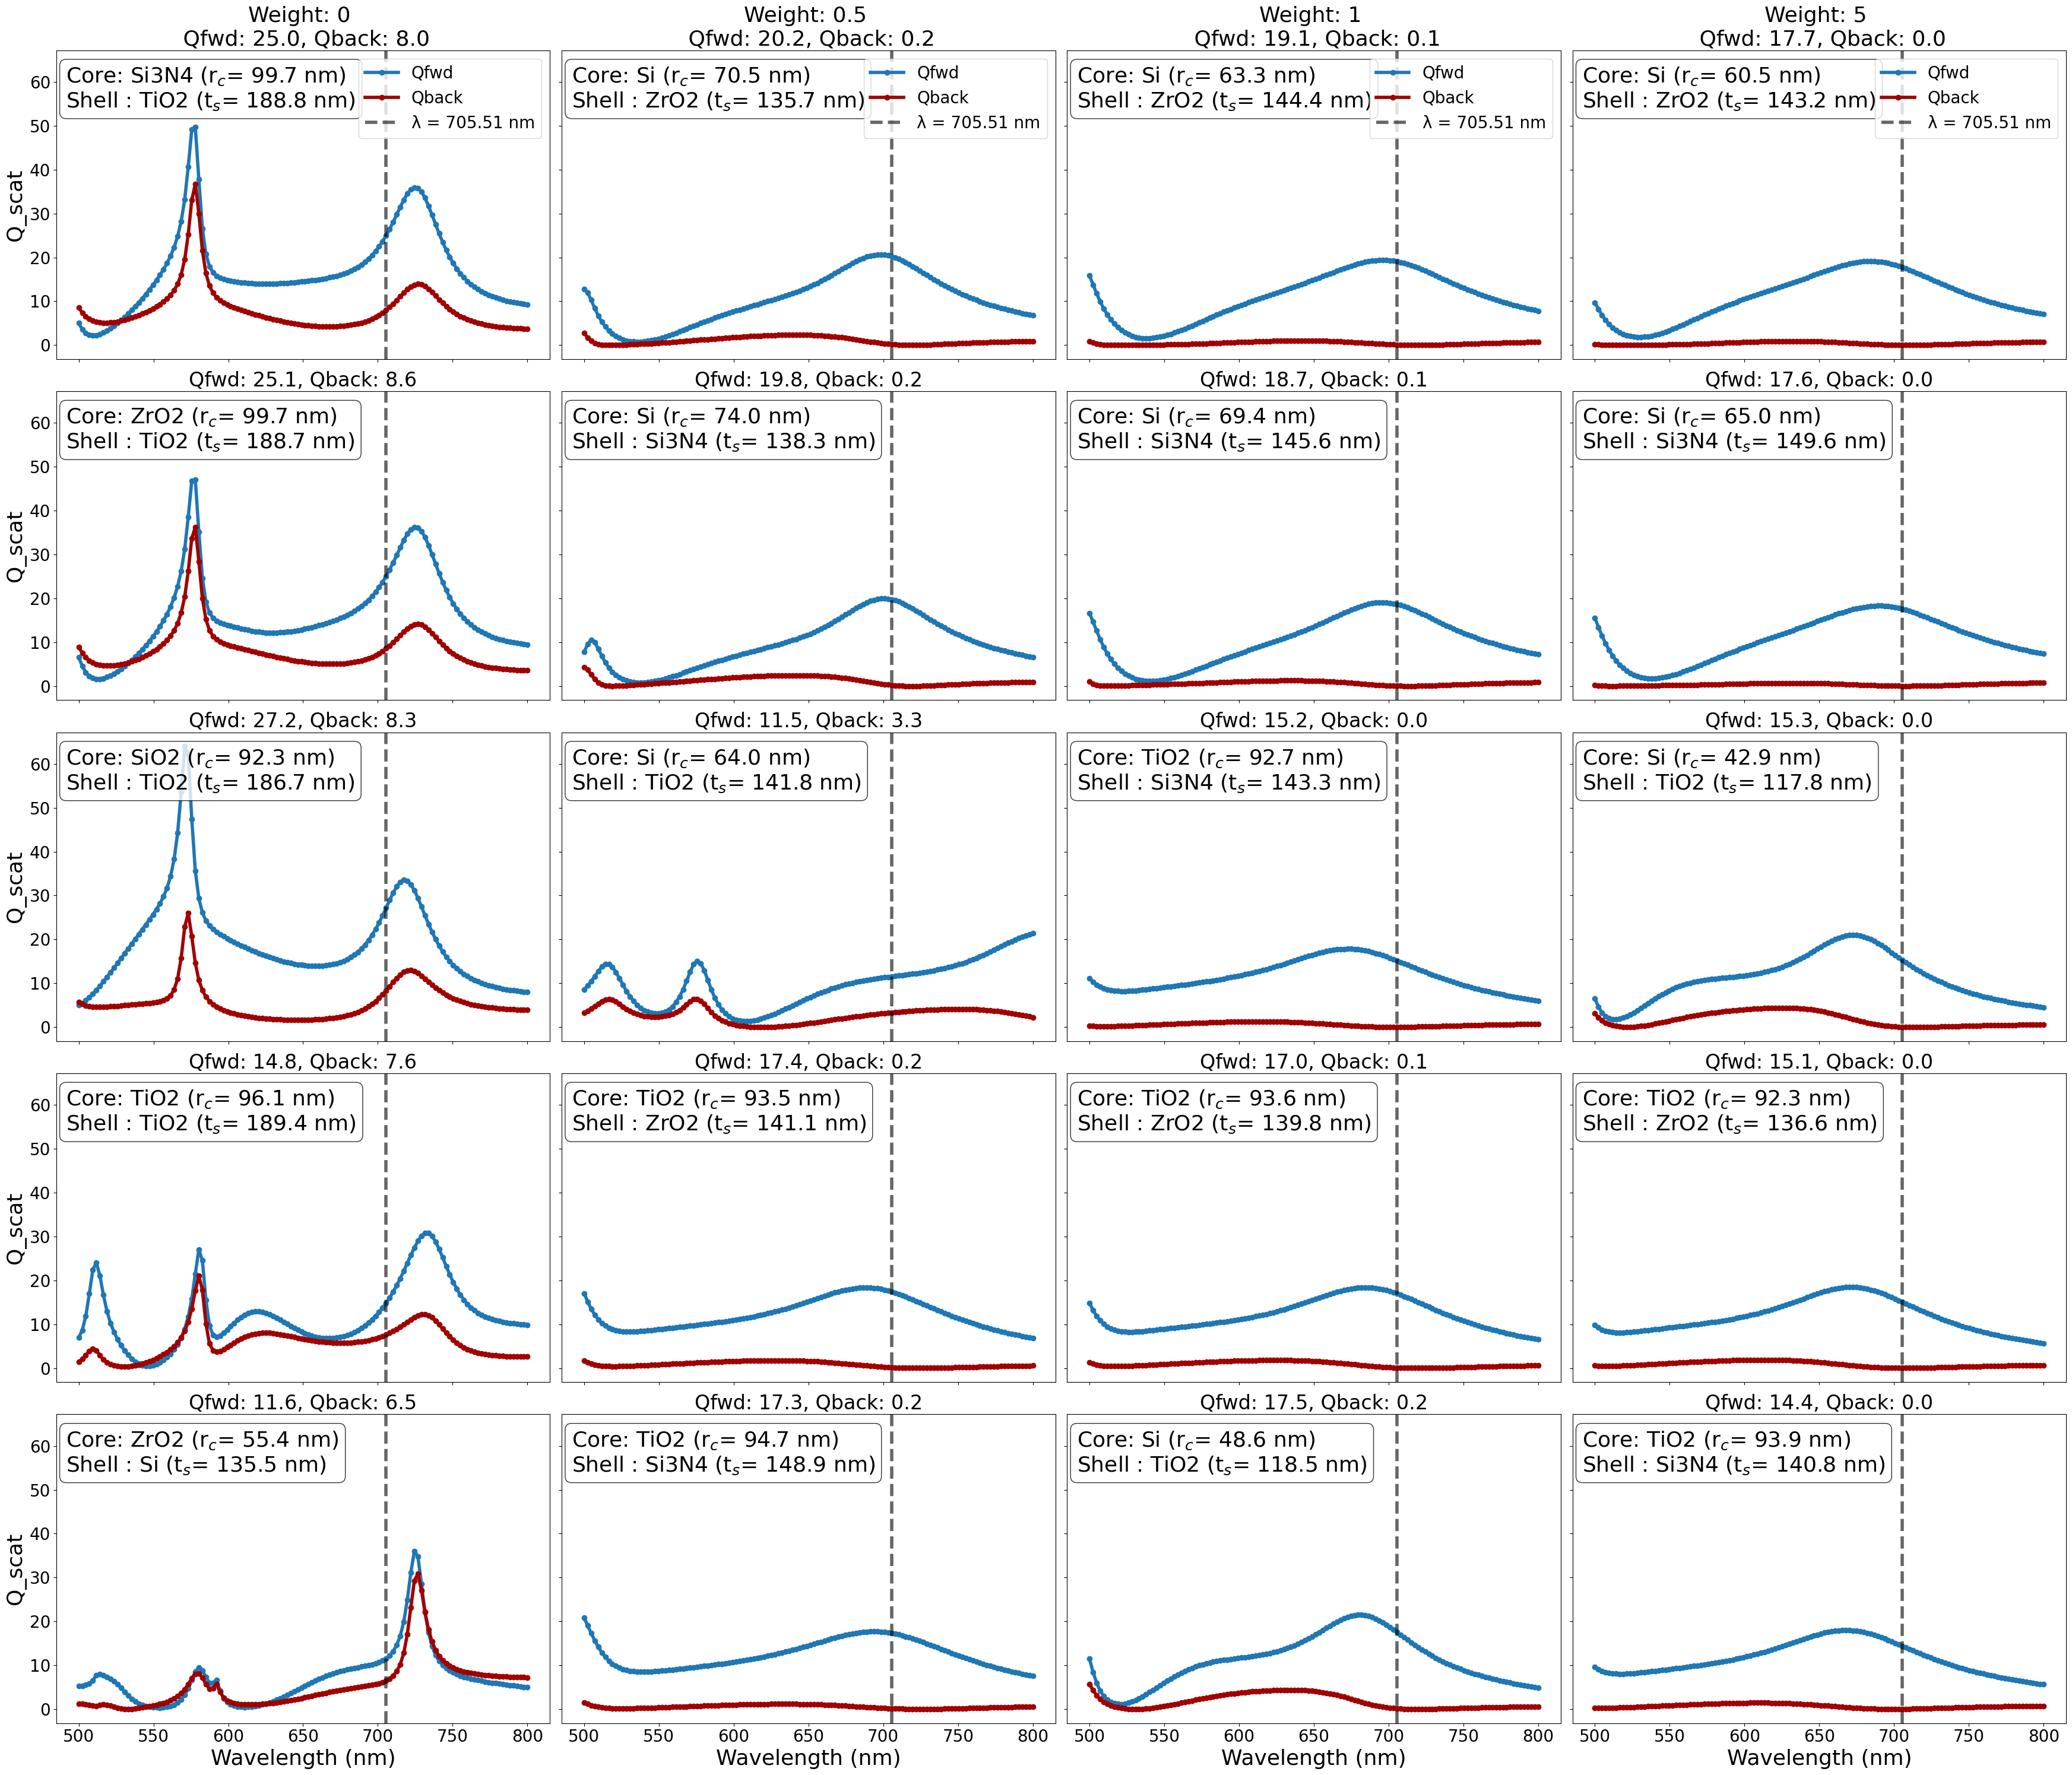

In [33]:
%run utils_plot.py
weight_series = [0, 0.5, 1, 5]
plot_best_geometries_by_weights(best_geometries_by_weight, wavelengths_original, wavelengths_new, weights=weight_series, target_lambda_index=target_lambda_index)